In [13]:
#!pip install pdpbox
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from sklearn.feature_selection import SelectKBest
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
#path="../../data/"
path="../../../ukb/data/"

In [14]:
from boruta import BorutaPy

In [15]:
from utils import *
from MLModels import *
from DataProcessing import *

In [16]:

config = dict(scale_pos_weight = 6,subsample = 1, min_child_weight = 5, max_depth = 5, gamma= 2, 
              colsample_bytree= 0.6,smote=1)

config_rebal = dict(scale_pos_weight = 1,subsample = 1, min_child_weight = 5, max_depth = 5, gamma= 2, 
              colsample_bytree= 0.6,smote=1)


mod_xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, learning_rate=0.1,
           max_delta_step=0,  missing=None,
           n_estimators=60, n_jobs=4, nthread=4, objective='binary:logistic',
           random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=config['scale_pos_weight'],
           min_child_weight=config['min_child_weight'],
           gamma=config['gamma'], colsample_bytree=config['colsample_bytree'],max_depth=config['max_depth'],
           seed=42, silent=None, subsample=1, verbosity=1)

mod_xgb_rebal=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, learning_rate=0.1,
           max_delta_step=0,  missing=None,
           n_estimators=60, n_jobs=4, nthread=4, objective='binary:logistic',
           random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=config_rebal['scale_pos_weight'],
           min_child_weight=config_rebal['min_child_weight'],
           gamma=config_rebal['gamma'], colsample_bytree=config_rebal['colsample_bytree'],max_depth=config_rebal['max_depth'],
           seed=42, silent=None, subsample=1, verbosity=1)

mod_rf = RandomForestClassifier(max_depth=5, random_state=0)

In [17]:

drpvars1='AD|hospital_episode_type_f41231_General|drive_faster\
|spells_in_hospital_f41235|sexual_partners|using_computer|interpolated_year|\
genotype_measurement_batch_f2200|\
f21052|f2188|f20463|coeliac|Unknown|death|APOE4|consultant|f20434|year_of_birth|age|set|\
history_of_psychiatric|carer_support|sunlamp|answered_sexual|samesex|death'

drpvars1='death|AD|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|testosterone|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|age|sexual_partners|using_computer|sex_inference'


drpvars1='death|AD|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|sexual_partners|using_computer|sex_inference|\
age_first_had|age_started|age_when|ageing|drive_faster'

drpvars_mod='AD|eid|CERVASCALL_bef|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|age|sexual_partners|using_computer|sex_inference|\
PD|EPIL|diabetes|DIAB'


drpvarsapoe='AD|hospital_episode_type_f41231_General\
|spells_in_hospital_f41235|sexual_partners|using_computer|interpolated_year|\
genotype_measurement_batch_f2200|\
f21052|f2188|f20463|coeliac|Unknown|death|APOE4|consultant|f20434|year_of_birth|age|set|APOE|Genotype'

drpvarsapoe='AD|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|Genotype|age'


drvarsdef=['DIAB','DIAB_bef','CERVASC','CERVASC_bef','PD','CERVASC','EPIL']

drpvarssurv='AD|DIAB|EPIL|CERVASC_bef|spells_in_hospital_f41235|\
hospital_episode_type_f41231_General episode|genotype_measurement_batch_f2200|consultant\
|Unknown|Not at all'

genos=[
 'Genotype_e1/e4',
 'Genotype_e2/e2',
 'Genotype_e2/e3',
 'Genotype_e2/e4',
 'Genotype_e3/e3',
 'Genotype_e3/e4',
 'Genotype_e4/e4']

genotypes=['Genotype_e1/e2',"Genotype_e2/e2","Genotype_e2/e3","Genotype_e3/e3","Genotype_e2/e4","Genotype_e1/e4",
          "Genotype_e3/e4","Genotype_e4/e4"]

gen_lkup={'Genotype_e2/e2':1,"Genotype_e1/e2":2,"Genotype_e2/e3":3,"Genotype_e3/e3":4,
          "Genotype_e2/e4":5,"Genotype_e1/e4":6,"Genotype_e3/e4":7,"Genotype_e4/e4":8}

gen_lkup_rev={1:'Genotype_e2/e2',2:"Genotype_e1/e2",3:"Genotype_e2/e3",4:"Genotype_e3/e3",
          5:"Genotype_e2/e4",6:"Genotype_e1/e4",7:"Genotype_e3/e4",8:"Genotype_e4/e4"}

def traintest_df(df,rat=0.7):
    maskAD=(df['AD']==1)
    
    sizeAD=len(df[maskAD])
    sizenoAD=len(df[~maskAD])
    sizeAD_tr=round(rat*sizeAD)
    sizenoAD_tr=round(rat*sizenoAD)
    
    train=pd.concat([df[maskAD].sample(sizeAD_tr),df[~maskAD].sample(sizenoAD_tr)],axis=0)
    test=df[~(df['eid'].isin(train['eid']))]
    return train,test

def score_df(df_train,df_val,dropcols,model,dropcolyn=1):
    if dropcolyn!=1:
        dropcols='AD'
        
    X_train=df_train.drop(columns=dropcols)
    y_train=df_train['AD']
    
    model_train=model.fit(X_train,y_train)
    
    X_test=df_val.drop(columns=dropcols)
    df_valout=df_val.copy()
    
    df_valout['risk']=model.predict_proba(X_test)[:, 1]
    return df_valout


       
def int_vars(df,var1,vars=genos):
    for var in vars:
        df[str(var1)+" "+var]=df[var]*df[var1]
    return df

def newfeats(df,shapsum,depvar='AD',feats=30):
    
    if feats==max:
        cols=[col for col in df if col in np.asarray(shapsum['column_name'])]
    
    else:
        cols=[col for col in df if col in np.asarray(shapsum.head(feats)['column_name'])]
    
    if 'eid' in cols:
        df_out=df[np.append(['AD'],cols)]   
    else:
        df_out=df[np.append(['AD','eid'],cols)]
    return df_out

def cleandf(df,alm=1):
    df=replacenullsmean(df)
    
    if alm==1:
        df['AST_ALT_ratio']=round((df['aspartate_aminotransferase_f30650']\
                                          /df['alanine_aminotransferase_f30620']),1)

    #change to any of the pollution metrics in the top 40%
        
        mask_sleep_mr=(df['sleep_duration_f1160'].between(6,8))
        mask_sleep_high=(df['sleep_duration_f1160']>8)
        
        df['sleep']=0
        df['sleep'][mask_sleep_mr]=1
        df['sleep'][mask_sleep_high]=2
        
        #pollution
        df['polluted']=0
        df['polluted'][(df['particulate_matter_air_pollution_pm25_absorbance_2010_f24007']>9)]=1


    df=col_spec_chars(df)
    #df=replace_genotype(df,gen_lkup,genotypes)
    return df

def maskapoedf(df,apoe=1):
    apoemask=(df['Genotype_e3/e4']==1)|(df['Genotype_e4/e4']==1)|\
    (df['Genotype_e2/e4']==1)|(df['Genotype_e1/e4']==1)
    non_apoemask=(df['Genotype_e2/e3']==1)|(df['Genotype_e3/e3']==1)|\
    (df['Genotype_e1/e2']==1)|(df['Genotype_e2/e2']==1)

    if apoe==2:
        return df[apoemask|non_apoemask]
    elif apoe==1:  
        return df[apoemask]
    elif apoe==0:  
        return df[non_apoemask]
    

def summarise_score_data(df):
    df=pd.DataFrame(df.groupby(['eid']).agg({'AD':'max','risk':['mean','std']})).reset_index()
    df.columns=['eid','AD','risk','std_risk']   
    return df

def runmodel(df,dropcols,reps,splits,model):
    
    dropcols=[col for col in dropcols if 'AD' not in dropcols]
    df_out=df.drop(columns=dropcols)
    df_test_out=pd.DataFrame([])
    for reps in range(reps):
        if reps-round(reps/5)*5==0:
            print(reps)
        kf = KFold(n_splits=splits,shuffle=True)

        for train_index, test_index in kf.split(df_out):
            df_train, df_test = df_out.iloc[train_index,: ], df_out.iloc[test_index, :]
            
            df_score=df_test[['eid','AD']]

            X_train, X_test = df_train.drop(columns='AD'), df_test.drop(columns='AD')
            y_train, y_test = df_train['AD'], df_test['AD']

            model.fit(X_train,y_train)   
            #plot_importance(model,max_num_features=10)
            
            boruta_selector = BorutaPy(model, n_estimators='auto', verbose = 2)

            boruta_selector.fit(np.array(X_train), np.array(y_train))
            
            df_score['risk']=model.predict_proba(X_test)[:, 1]
            df_test_out=pd.concat([df_test_out,df_score])
    df_test_out=summarise_score_data(df_test_out)
    print(df_test_out.shape)
    return df_test_out




def plot_ROCAUC_mult(y_test, y_score,y_test1,y_score1,y_test2,y_score2,title,l1,l2,l3):
    
    
    fpr, tpr, _ = roc_curve(y_test,y_score)
    fpr1, tpr1, _ = roc_curve(y_test1,y_score1)
    fpr2, tpr2, _ = roc_curve(y_test2,y_score2)
    
    colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet'] 
    
    mean_auc = auc(fpr, tpr)
    mean_auc1 = auc(fpr1, tpr1)
    mean_auc2 = auc(fpr2, tpr2)
   
    
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_score))


    plt.plot(fpr, tpr, 'b', alpha = 0.8,
             label=r'%s (AUC = %0.2f)' % (l1,mean_auc))
    plt.plot(fpr1, tpr1, 'c', alpha = 0.8,
             label=r'%s apoe (AUC = %0.2f)' % (l2,mean_auc1))
    plt.plot(fpr2, tpr2, 'm', alpha = 0.8,
             label=r'%s non apoe (AUC = %0.2f)' % (l3,mean_auc2))

    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Luck', alpha= 0.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)
    #plt.axes().set_aspect('equal', 'datalim')
    plt.show()


In [18]:
AD_model_full70SNP=pd.read_pickle('%s%s' % (path,'AD_model_full70SNP.p'))

In [38]:
mask_PD=(AD_model_full70SNP['PD']==1)
mask_AD=(AD_model_full70SNP['AD']==1)

In [44]:
AD_model_full70SNP_ADPD=AD_model_full70SNP[(mask_PD|mask_AD)&(~(mask_PD&mask_AD))]

In [ ]:
AD_model_full70SNP[]

In [46]:
AD_model_full70SNP_ADPD['PD'].value_counts()

0    1780
1    1597
Name: PD, dtype: int64

In [48]:
def summarisevars(df,snps=snps,depvar="AD"):
    for var in snps:
        print(AD_model_full70SNP_ADPD.groupby(var).agg({'AD':['mean','count']}))

In [49]:
summarisevars(AD_model_full70SNP_ADPD)

     AD      
   mean count
AD           
0     0  1597
1     1  1780
          AD      
        mean count
eid               
1001664    0     1
1001924    0     1
1002957    1     1
1004748    0     1
1005617    0     1
...      ...   ...
6020005    0     1
6020084    0     1
6022143    1     1
6024255    1     1
6025140    1     1

[3377 rows x 2 columns]
                     AD      
                   mean count
rs3818361_0 0                
0              0.526441  3366
1              0.727273    11
                     AD      
                   mean count
rs3818361_A A                
0              0.527452  3242
1              0.518519   135
                     AD      
                   mean count
rs3818361_A G                
0              0.517617  2384
1              0.549849   993
                     AD      
                   mean count
rs3818361_G G                
0              0.547849  1139
1              0.516533  2238
                    AD      
          

                     AD      
                   mean count
rs8093731_T T                
0              0.527267  3374
1              0.333333     3
                     AD      
                   mean count
rs3865444_0 0                
0              0.526879  3367
1              0.600000    10
                     AD      
                   mean count
rs3865444_A A                
0              0.531138  3067
1              0.487097   310
                     AD      
                   mean count
rs3865444_A C                
0              0.538817  1945
1              0.511173  1432
                     AD      
                   mean count
rs3865444_C C                
0              0.507420  1752
1              0.548308  1625
                     AD      
                   mean count
rs7274581_0 0                
0              0.520956  3054
1              0.585139   323
                     AD      
                   mean count
rs7274581_C C                
0         

In [35]:
snps=['AD','eid','rs3818361_0 0',
 'rs3818361_A A',
 'rs3818361_A G',
 'rs3818361_G G',
 'rs744373_0 0',
 'rs744373_A A',
 'rs744373_G A',
 'rs744373_G G',
 'rs35349669_0 0',
 'rs35349669_C C',
 'rs35349669_T C',
 'rs35349669_T T',
 'rs190982_0 0',
 'rs190982_A A',
 'rs190982_G A',
 'rs190982_G G',
 'rs2718058_0 0',
 'rs2718058_A A',
 'rs2718058_G A',
 'rs2718058_G G',
 'rs1476679_0 0',
 'rs1476679_C C',
 'rs1476679_C T',
 'rs1476679_T T',
 'rs11771145_0 0',
 'rs11771145_A A',
 'rs11771145_A G',
 'rs11771145_G G',
 'rs11136000_0 0',
 'rs11136000_C C',
 'rs11136000_C T',
 'rs11136000_T T',
 'rs28834970_0 0',
 'rs28834970_C C',
 'rs28834970_T C',
 'rs28834970_T T',
 'rs10838725_0 0',
 'rs10838725_C T',
 'rs10838725_T T',
 'rs610932_0 0',
 'rs610932_G G',
 'rs610932_T G',
 'rs610932_T T',
 'rs3851179_0 0',
 'rs3851179_C C',
 'rs3851179_T C',
 'rs3851179_T T',
 'rs17125944_0 0',
 'rs17125944_C C',
 'rs17125944_C T',
 'rs17125944_T T',
 'rs10498633_0 0',
 'rs10498633_G G',
 'rs10498633_T G',
 'rs10498633_T T',
 'rs8093731_0 0',
 'rs8093731_C C',
 'rs8093731_T C',
 'rs8093731_T T',
 'rs3865444_0 0',
 'rs3865444_A A',
 'rs3865444_A C',
 'rs3865444_C C',
 'rs7274581_0 0',
 'rs7274581_C C',
 'rs7274581_C T',
 'rs7274581_T T']


#### Data Cleaning

In [50]:
AD_model_full70SNP=cleandf(AD_model_full70SNP,alm=1)
AD_model_full_gfilt=maskapoedf(AD_model_full70SNP,apoe=2)

AD_model_full70SNP_ADPD=cleandf(AD_model_full70SNP,alm=1)
AD_model_full70SNP_ADPD=maskapoedf(AD_model_full70SNP_ADPD,apoe=2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
AD_model_full_gfilt_apoe=maskapoedf(AD_model_full_gfilt,apoe=1)
AD_model_full_gfilt_nonapoe=maskapoedf(AD_model_full_gfilt,apoe=0)


In [22]:
dropvars_gfilt=varstodrop(AD_model_full_gfilt,drpvars1,drvarsdef)

In [51]:
dropvars_snp_ADPD=varstodrop(AD_model_full70SNP_ADPD,drpvars1,drvarsdef)

#### Run Models

In [ ]:
varimp_full,score_g=newmodelrun(AD_model_full70SNP_ADPD,dropvars=dropvars_snp_ADPD,model=mod_xgb,depvar='AD',
                    reps=1,splits=5,rebalance=0,max_display=15,plot_type="dot",shap=1,plots=1)

iteration: 0



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


iteration: 0



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


Accuracy : 0.9906
0.0
AUC Score (Train): 0.519795


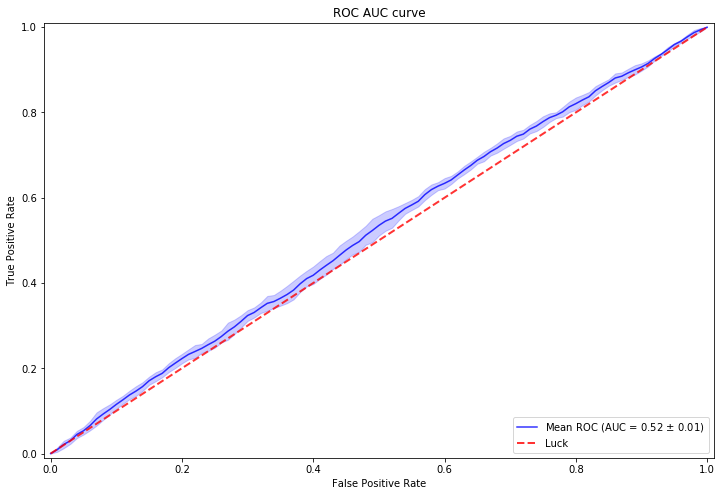

SHAP summary dot plot for selected feature number


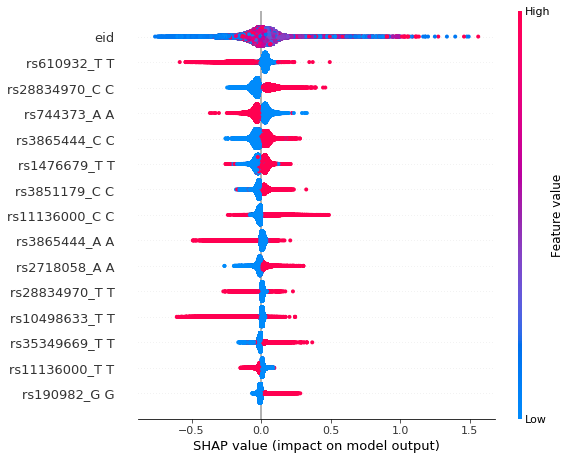

SHAP summary dot plot for 35 features


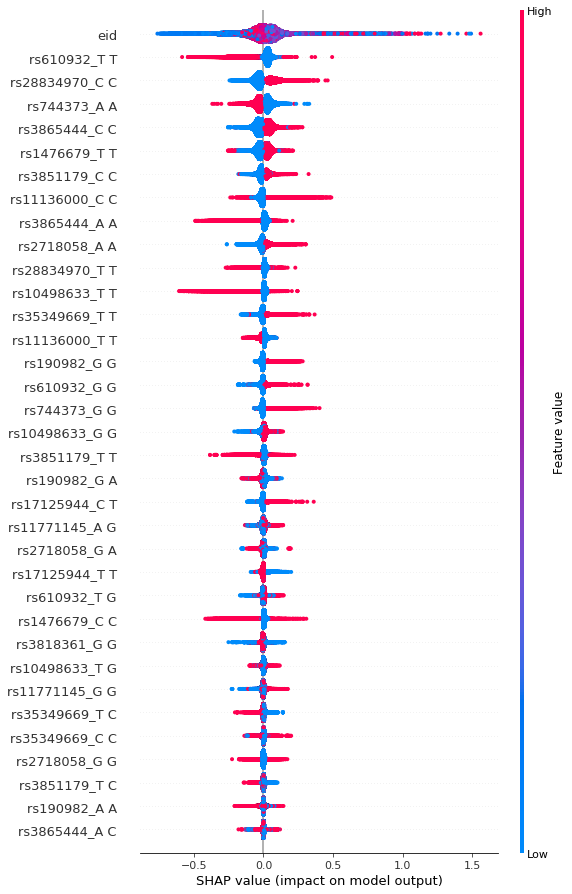

In [36]:
#just on the SNPs first
varimp_full,score_g=newmodelrun(AD_model_full_gfilt[snps],dropvars='AD',model=mod_xgb,depvar='AD',
                    reps=1,splits=5,rebalance=0,max_display=15,plot_type="dot",shap=1,plots=1)

iteration: 0



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


Accuracy : 0.9903
76.0
AUC Score (Train): 0.811508


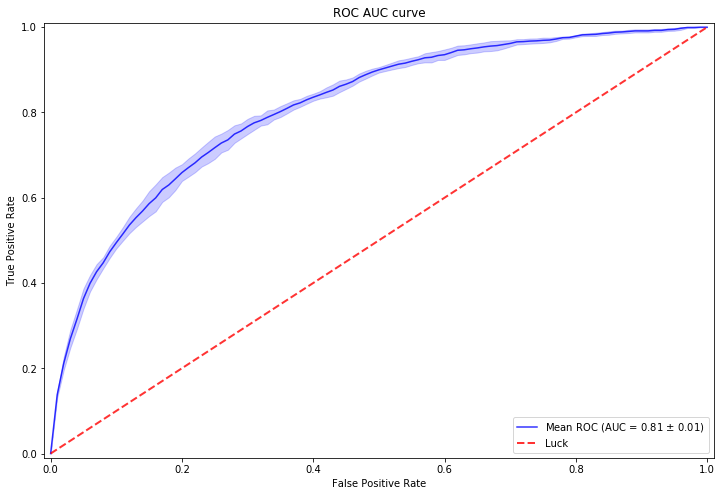

SHAP summary dot plot for selected feature number


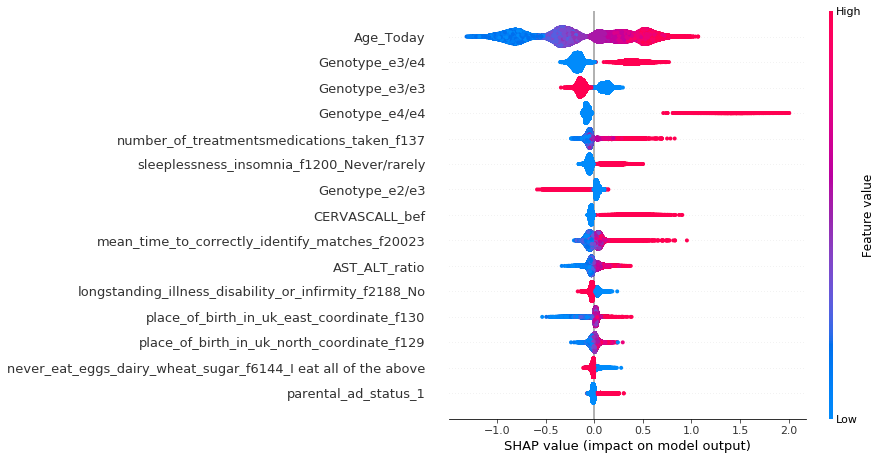

SHAP summary dot plot for 35 features


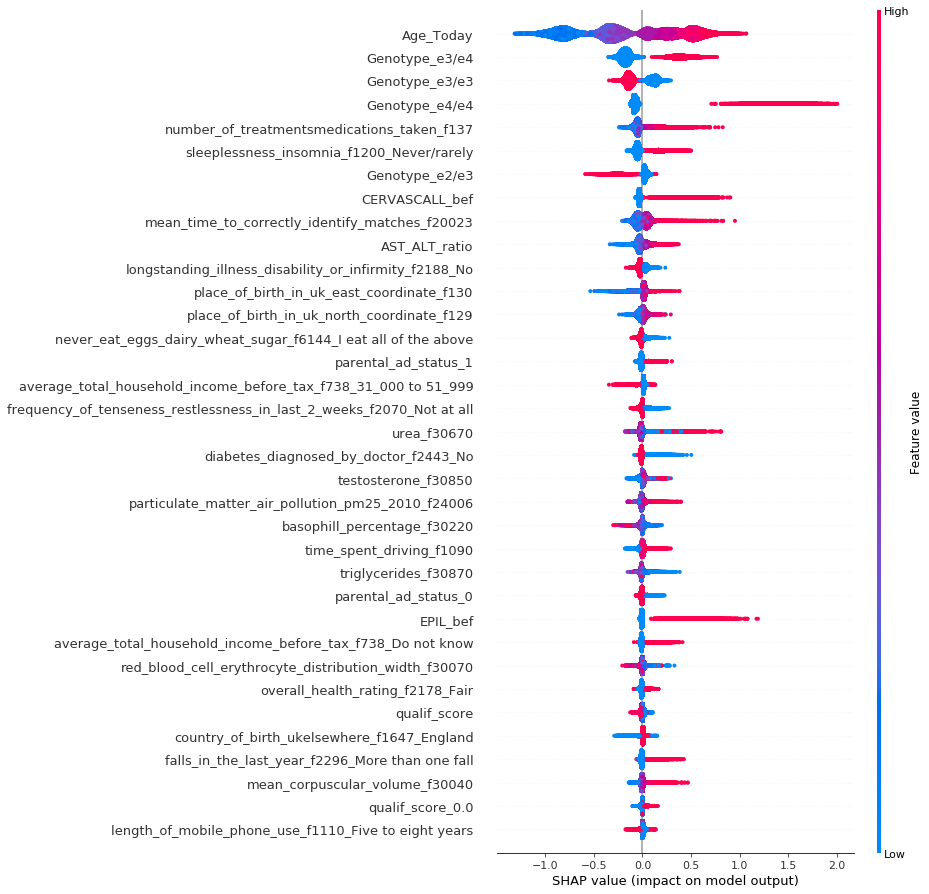

iteration: 0



Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


Accuracy : 0.9783
59.0
AUC Score (Train): 0.763042


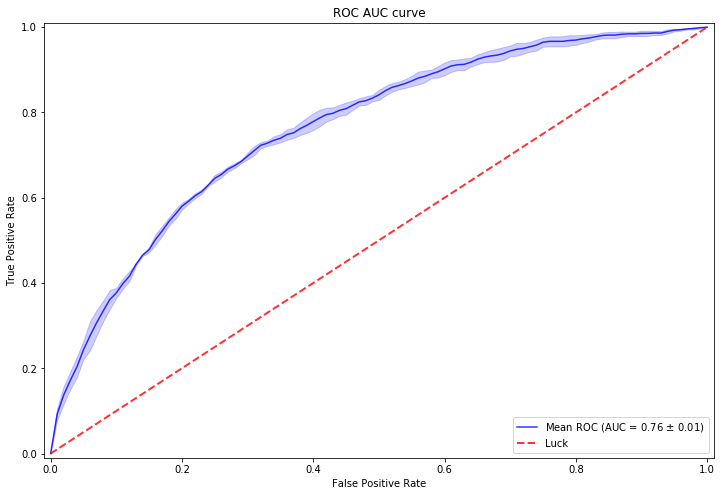

SHAP summary dot plot for selected feature number


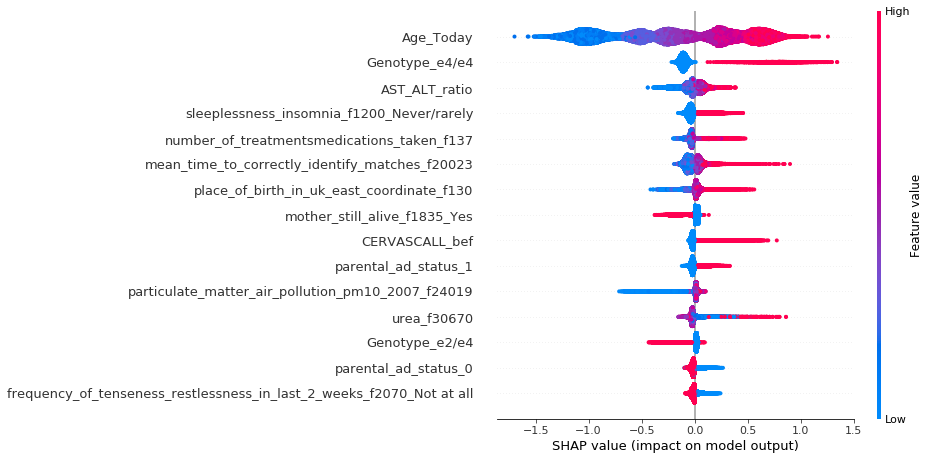

SHAP summary dot plot for 35 features


KeyboardInterrupt: 

In [23]:
varimp_full,score_g=newmodelrun(AD_model_full_gfilt,dropvars=dropvars_gfilt,model=mod_xgb,depvar='AD',
                    reps=1,splits=5,rebalance=0,max_display=15,plot_type="dot",shap=1,plots=1)
varimp_full_apoe_pos,score_apoe_g=newmodelrun(AD_model_full_gfilt_apoe,dropvars=dropvars_gfilt,model=mod_xgb,depvar='AD',
                    reps=1,splits=3,rebalance=0,max_display=15,plot_type="dot",shap=1,plots=1)
varimp_full_apoe_neg,score_napoe_g=newmodelrun(AD_model_full_gfilt_nonapoe,dropvars=dropvars_gfilt,model=mod_xgb,depvar='AD',
                    reps=1,splits=3,rebalance=0,max_display=15,plot_type="dot",shap=1,plots=1)

In [32]:
mask_rs=(varimp_full.column_name.apply(lambda x:x[0:2])=="rs")

varimp_full[mask_rs]

,column_name,mean_shap_imp,std_shap_imp,min_rank,max_rank,mean_rank,median_rank,std_rank
1067,rs28834970_C C,0.006250,0.005989,28,624,192.0,69,247.877994
1056,rs17125944_C T,0.003679,0.003509,54,597,282.8,86,287.076122
1053,rs1476679_T T,0.002675,0.003382,63,631,261.8,236,227.790913
1095,rs744373_A A,0.002412,0.000972,117,193,160.0,176,32.326460
1085,rs3865444_C C,0.002099,0.002767,67,613,329.6,236,263.999621
...,...,...,...,...,...,...,...,...
1042,rs11136000_0 0,0.000000,0.000000,625,644,635.8,635,7.120393
1046,rs11771145_0 0,0.000000,0.000000,622,640,632.8,633,6.833740
1054,rs17125944_0 0,0.000000,0.000000,586,606,596.6,595,7.503333
1055,rs17125944_C C,0.000000,0.000000,587,607,597.6,596,7.503333


In [15]:
varimp_full.to_csv('%s%s' % (path,'varimp_full_snp.csv'))
varimp_full_apoe_pos.to_csv('%s%s' % (path,'vvarimp_full_apoe_pos_snp.csv'))
varimp_full_apoe_neg.to_csv('%s%s' % (path,'varimp_full_apoe_neg_snp.csv'))

AUC Score (Train): 0.818764


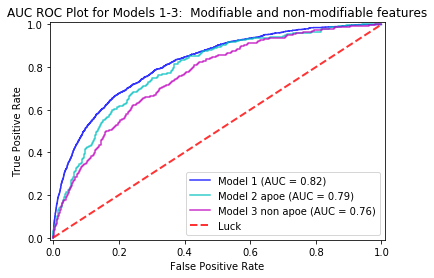

In [47]:
plot_ROCAUC_mult(score_g['actual'], score_g['mean_score'],score_apoe_g['actual'],
                 score_apoe_g['mean_score'],
                 score_napoe_g['actual'],
                 score_napoe_g['mean_score'],title='AUC ROC Plot for Models 1-3:  Modifiable and non-modifiable features',
                 l1='Model 1',l2='Model 2',l3='Model 3')